In [133]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import os
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator

# statsmodels and sklearn are currently not used. Both packages can be omitted for now, but sklearn will
# very likely be used in the future

%matplotlib inline

# Folder containing the data file
data_dir = r'F:\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\Preeclampsia Model\RTG11\QUS_Processing_Andrew' # on desktop
data_dir = r'C:\Users\cah4016\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\Preeclampsia Model\RTG11\QUS_Processing_Andrew' # on laptop
data_dir = r'F:\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\IUS_2023' # For IUS 2023 abstract
data_dir = r'C:\Users\acm4005\Box\WCM_Tulane_Shared_Folder\Preeclampsia Model' # For UITC 2023 talk

# Name of the file containing the QUS results
#data_fid = r'2023-03-07_GD14-18.csv'
data_fid = r'2023-07-21.csv'

# Define an array of the QUS parameter names. This will be useful later
qus_params = ['ESD','EAC','MBF','SS','I0','Naka Omega','Naka m','HK k','HK alpha','Burr b','Burr lambda']

# Move to the data folder and read the .csv into a DataFrame
os.chdir(data_dir)
in_data = pd.read_csv(data_fid)

# Rename the columns using abbreviations for the parameter names
new_names = {'HK Structure Param':'HK k','HK Scatterer Clustering Param':'HK alpha','Nak Shape Param':'Naka m','Nak Scale Factor':'Naka Omega', 
             'Spectral Slope':'SS','Intercept':'I0','Midband Fit':'MBF','Effective Scatterer Size':'ESD','Acoustic Concentration':'EAC',
             'Burr_b':'Burr b','Burr_lambda':'Burr lambda'}
in_data.rename(new_names,axis=1,inplace=True)

# Convert ESD from m to um
in_data['ESD'] *= 1e6

# Log compress the Nakagami Omega and HK alpha parameters
in_data['Naka Omega'] = np.log10(in_data['Naka Omega'])
in_data['HK alpha'] = np.log10(in_data['HK alpha'])

# As a precaution, remove any rows that contain a NaN in any column
in_data.dropna(axis=0,inplace=True)

# Based on the ID string, split into new columns with ID, Day, and Frame #
in_data[['ID','Day','Frame']] = in_data['ID'].str.split('_',2,expand=True)

# Convert Day column into integer data type (instead of string)
in_data['Day'] = in_data['Day'].astype(int)

in_data_copy = in_data.copy()

# # Keep only the first 5 characters from the ID - the last specifies placenta (not animal) and is not needed at this time
# # This will make it easier to separate the control and treat groups
# in_data['ID'] = in_data['ID'].str[:5]

# Remove any rows where the ESD is zero 
# This means QUS estimation failed
remove_idx = (in_data['ESD'] <= 0)
in_data.drop(in_data.loc[remove_idx].index,inplace=True)

in_data_copy = in_data.copy()

sum_data = in_data.groupby(['ID','Day'],as_index=False).count()

#Specify placentas which do not meet the criteria for inclusion in this study
drop_placentas = {'RTG341','RTG342'}

for drop_p in drop_placentas:
    in_data_copy.drop(in_data.loc[in_data['ID'] == drop_p].index,inplace=True)


# Rename the Group IDs to 'Control' and 'RUPP'
in_data.loc[in_data['ID'].str[:5] == 'RTG11','Group'] = 'Control'
in_data.loc[in_data['ID'].str[:5] == 'RTG36','Group'] = 'Control'
in_data.loc[in_data['ID'].str[:5] == 'RTG37','Group'] = 'Control'
in_data.loc[in_data['ID'].str[:5] == 'RTG43','Group'] = 'Control'
in_data.loc[in_data['ID'].str[:5] == 'RTG34','Group'] = 'RUPP'
in_data.loc[in_data['ID'].str[:5] == 'RTG44','Group'] = 'RUPP'
in_data.loc[in_data['ID'].str[:5] == 'RTG46','Group'] = 'RUPP'

#Generate string to save file
in_data_18 = in_data[in_data['Day']==18]
in_data_18.drop(columns = ['Day','Frame'],inplace=True)
#in_data_18 = in_data_18.groupby(['ID'],as_index=False)
save_csv = data_dir + r'\day_18_data_' + data_fid[:-4] + r'.csv'

#with pd.ExcelWriter(save_xls) as writer:
#     in_data_18.to_excel(writer)

in_data_18.to_csv(save_csv)

c:\Users\acm4005\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\1676364144.py:52: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  in_data[['ID','Day','Frame']] = in_data['ID'].str.split('_',2,expand=True)
C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\1676364144.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_data_18.drop(columns = ['Day','Frame'],inplace=True)


In [135]:
in_data_copy[in_data_copy['ID']=='RTG342']

Empty DataFrame
Columns: [HK k, HK alpha, Naka m, Naka Omega, SS, I0, MBF, ESD, EAC, ROI Z Dist, XCoord, YCoord, ZCoord, ID, Day, Frame]
Index: []

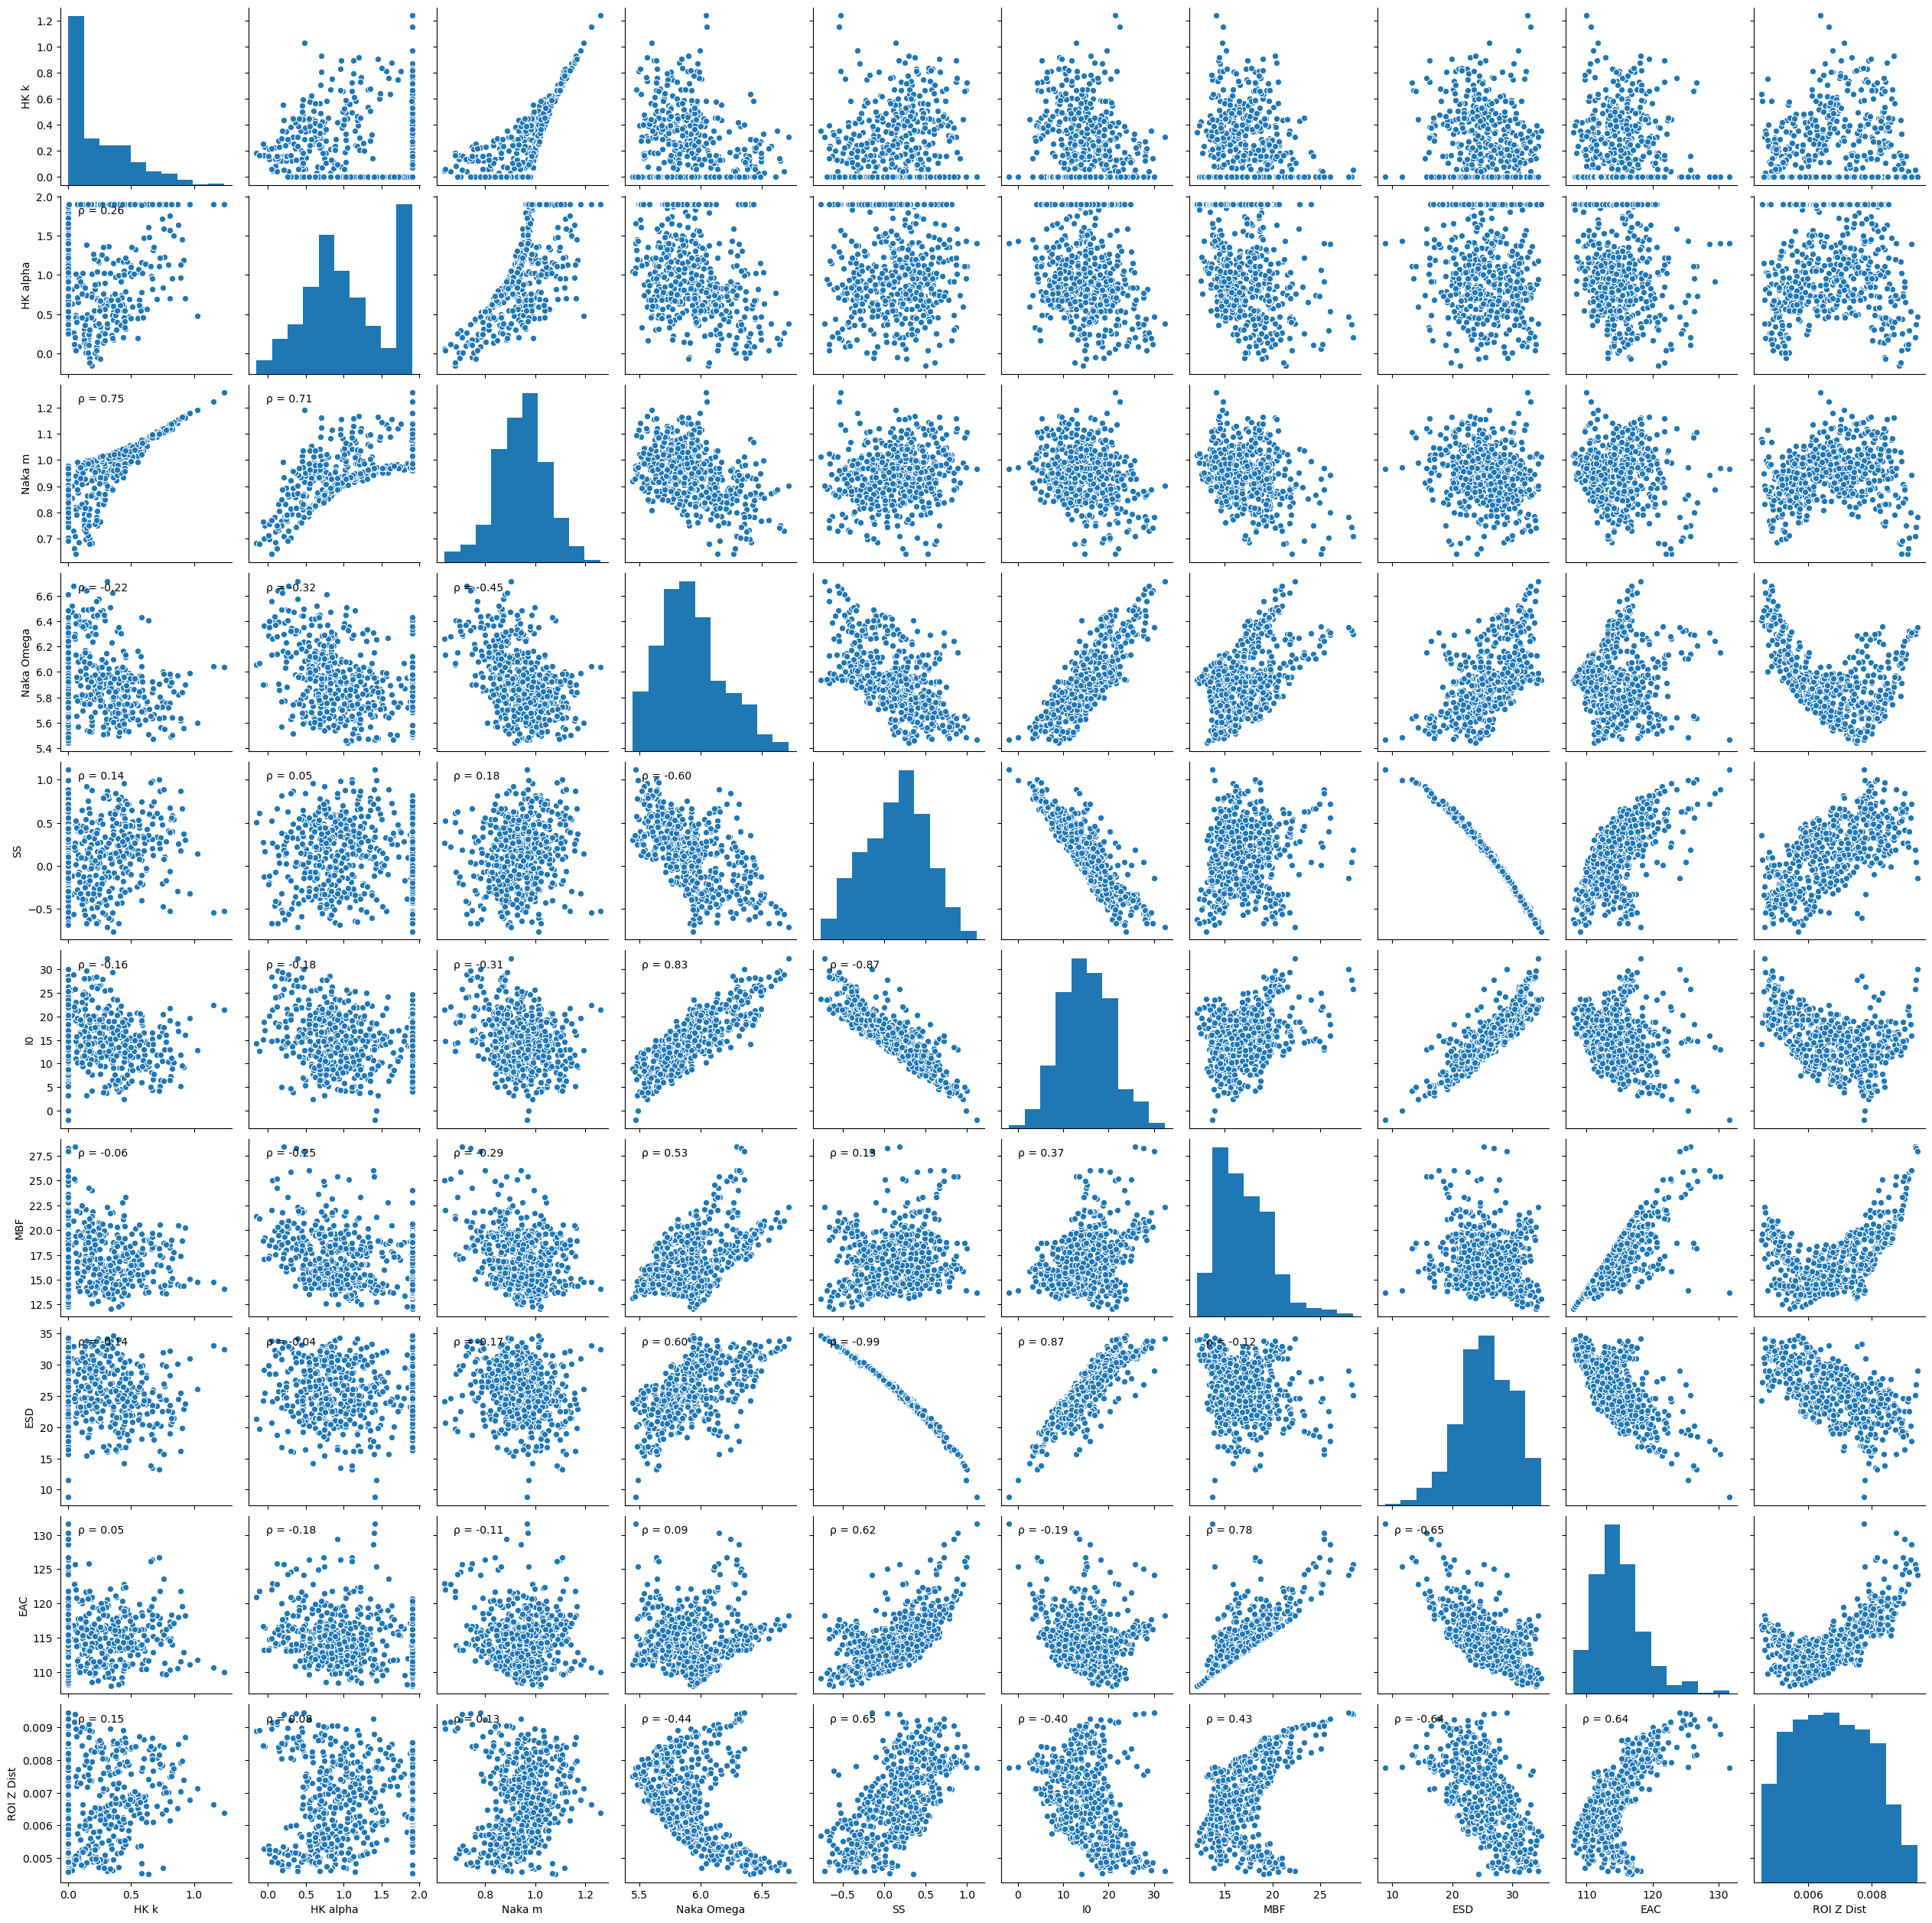

In [101]:
from scipy.stats import pearsonr

#Get the data from an example placenta on day 18
sample_data = in_data[in_data['ID'] == 'RTG374']
sample_data = sample_data[sample_data['Day'] == 18]
#print(sample_data.iloc[1])
sample_data.drop(columns = ['XCoord','YCoord','ZCoord','Day','Frame'],inplace=True)
#Create a pair plot of the data points within the placenta
g = sns.pairplot(sample_data)

#Compute pearsons correlation for each pair and display
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g.map_lower(corrfunc)

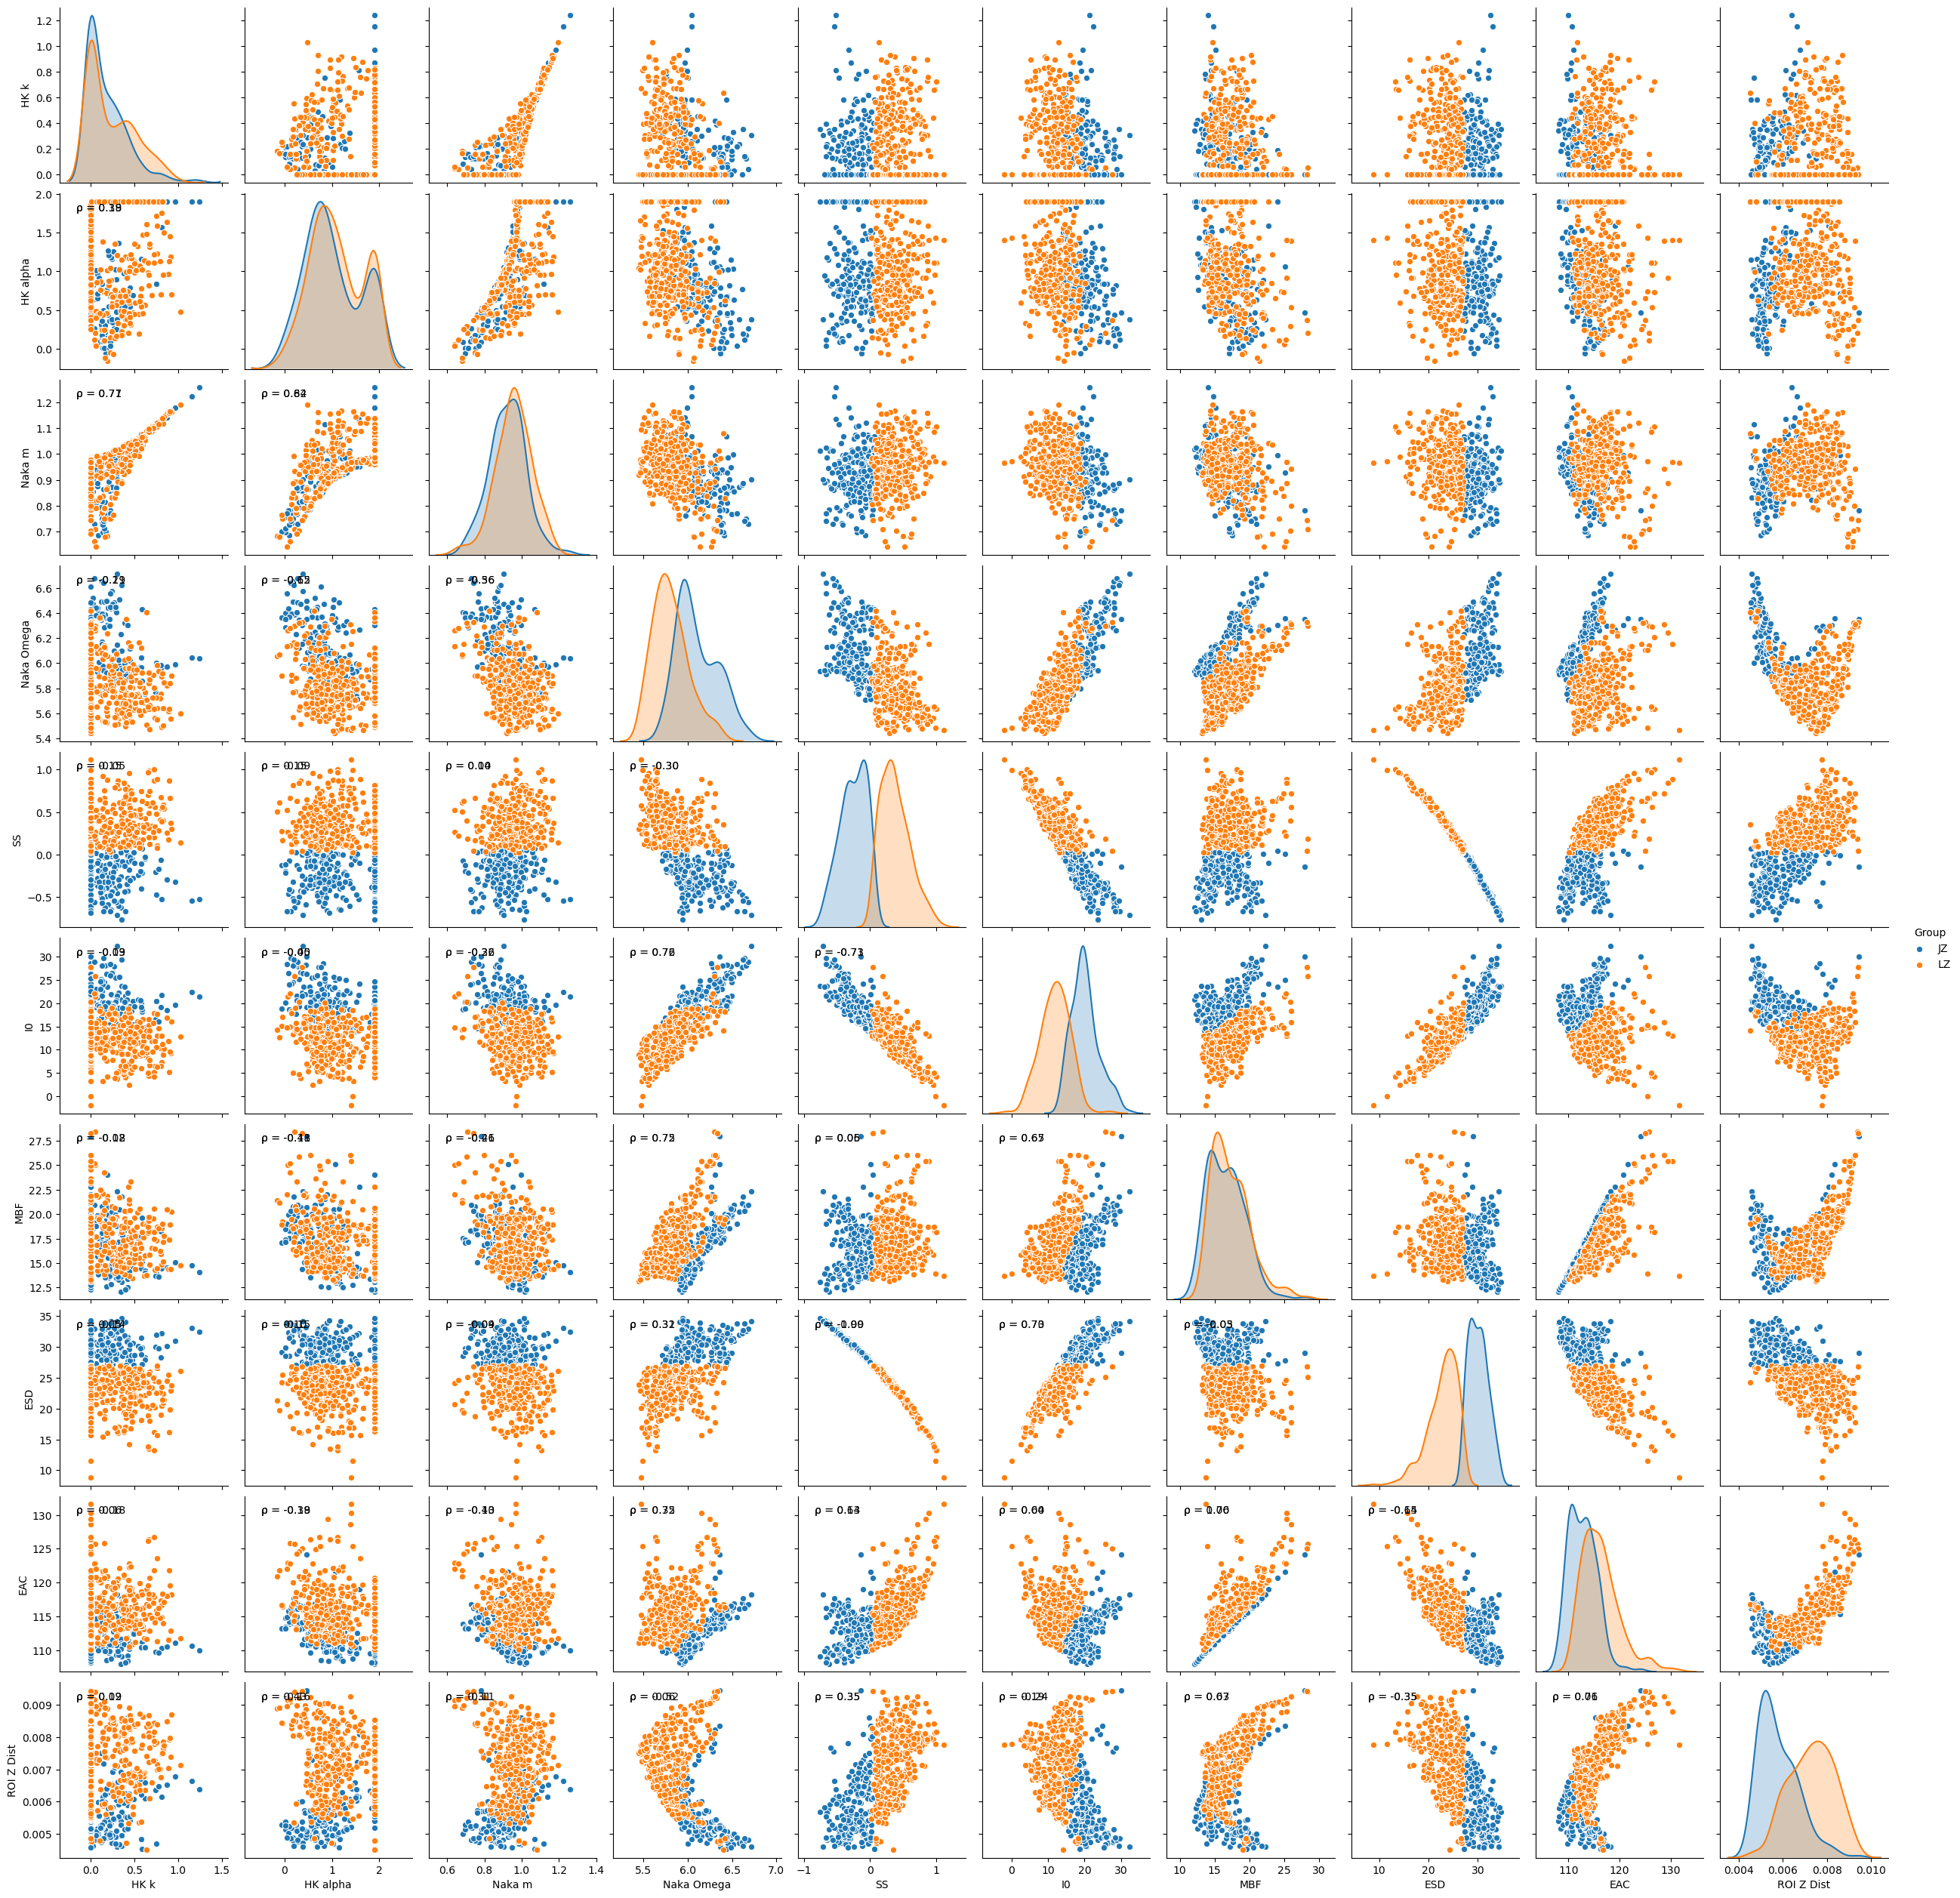

In [102]:
from scipy.stats import pearsonr

#Set threshold for Labyrinth and Junctional Zones
thresh = 27
#Get the data from an example placenta on day 18
sample_data.loc[sample_data['ESD'] < thresh,'Group'] = 'LZ'
sample_data.loc[sample_data['ESD'] >= thresh,'Group'] = 'JZ'
#Create a pair plot of the data points within the placenta
g = sns.pairplot(sample_data,hue="Group")

#Compute pearsons correlation for each pair and display
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g.map_lower(corrfunc)

Text(0, 0.5, 'Number of pixels')

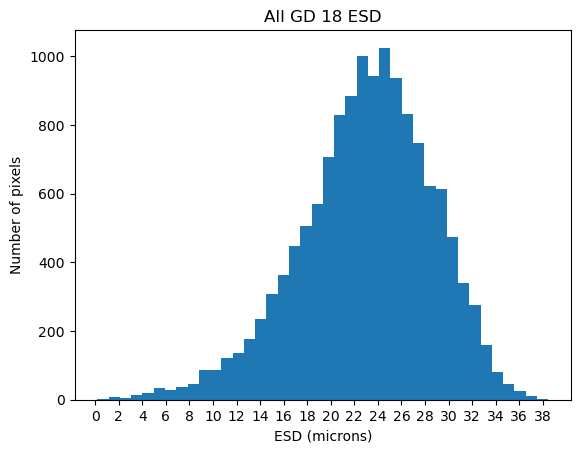

In [103]:
#Get all of the Day 18 ESD values and create a histogram
in_data_18 = in_data[in_data['Day']==18]
all_ESD_18 = in_data_18['ESD']
plt.hist(all_ESD_18,bins=40)
plt.xticks(np.arange(0, 40, step=2))
plt.title('All GD 18 ESD')
plt.xlabel('ESD (microns)')
plt.ylabel('Number of pixels')

Text(0, 0.5, 'Number of pixels')

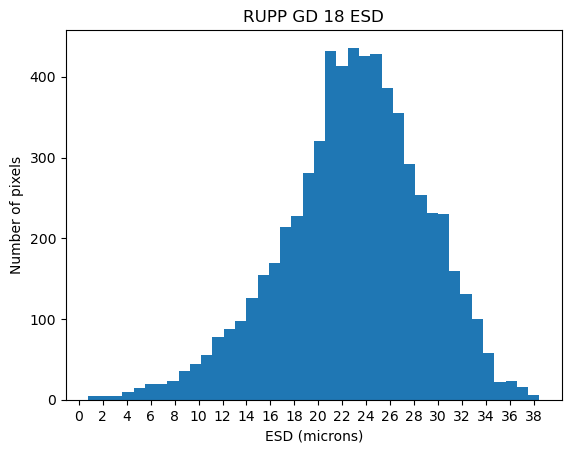

In [104]:

in_data_18_RUPP = in_data[in_data['Group']=='RUPP']
RUPP_ESD_18 = in_data_18_RUPP['ESD']
plt.hist(RUPP_ESD_18,bins=40)
plt.xticks(np.arange(0, 40, step=2))
plt.title('RUPP GD 18 ESD')
plt.xlabel('ESD (microns)')
plt.ylabel('Number of pixels')

Text(0, 0.5, 'Number of pixels')

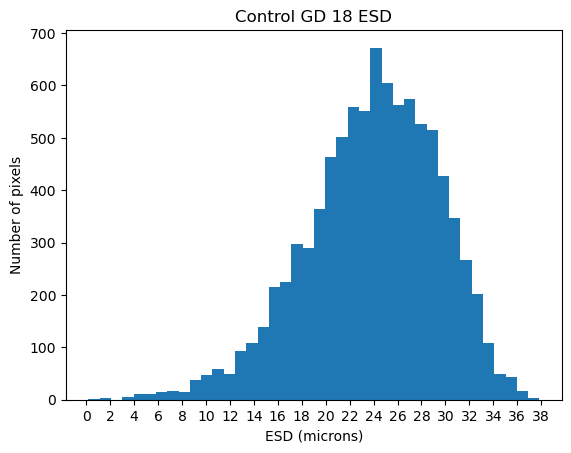

In [105]:

in_data_18_Control = in_data[in_data['Group']=='Control']
Control_ESD_18 = in_data_18_Control['ESD']
plt.hist(Control_ESD_18,bins=40)
plt.xticks(np.arange(0, 40, step=2))
plt.title('Control GD 18 ESD')
plt.xlabel('ESD (microns)')
plt.ylabel('Number of pixels')

Text(0, 0.5, 'Number of pixels')

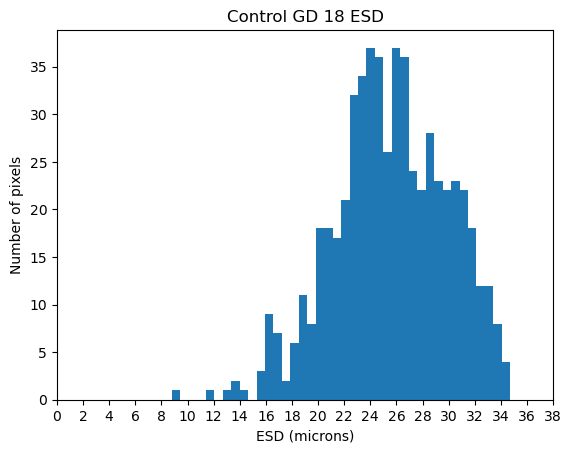

In [115]:
in_data_18_Control = in_data[in_data['Group']=='Control']
in_data_18_Control = in_data_18_Control[in_data_18_Control['ID']=='RTG374']
Control_ESD_18 = in_data_18_Control['ESD']
plt.hist(Control_ESD_18,bins=40)
plt.xticks(np.arange(0, 40, step=2))
plt.title('Control GD 18 ESD')
plt.xlabel('ESD (microns)')
plt.ylabel('Number of pixels')

In [106]:
#Create an alphabetized list of all ids with no duplicates
control_ids = sorted(set(in_data_18_Control['ID']))
remove_ids = [] #Ids to remove if they do not meet the right criteria
thresh = 27
control_lz = [] ## Of pixels in labyrith zone below threshold
control_jz = [] ## Of pixels in junctional zone below threshold
control_jl = [] #Ratio of labyrinth to junctional zone

for i in control_ids:
    placenta_i = in_data_18_Control[in_data_18_Control['ID'] == i]
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(placenta_i)
    ESD_i = placenta_i['ESD']
    li = ESD_i[ESD_i < thresh].count()
    ji = ESD_i[ESD_i >= thresh].count()

    control_lz.append(li)
    control_jz.append(ji)
    control_jl.append(ji/li)
'''
    if li == 0 or ji == 0:
        #remove_ids.append(i)
        print(i)
    elif ji >= li:
        #remove_ids.append(i) 
        print(i)
    else: 
        control_lz.append(li)
        control_jz.append(ji)
        control_jl.append(ji/li)
'''

#for r in remove_ids:
#    control_ids.remove(r)

print(len(control_lz))
print(len(control_ids))

control_zones = pd.DataFrame({'ID':control_ids, 'LZ':control_lz, 'JZ':control_jz, 'JZ/LZ':control_jl})

#Add the average and standard deviation to the end of the dataframe
control_zones.loc[len(control_zones.index)] = ['Avg', np.mean(control_lz), np.mean(control_jz), np.mean(control_jl)]
control_zones.loc[len(control_zones.index)] = ['StDev', np.std(control_lz), np.std(control_jz), np.std(control_jl)]

#Generate string to save file
save_xls = data_dir + r'\control_jl_' + data_fid[:-4] + r'.xlsx'

#with pd.ExcelWriter(r'C:\Users\acm4005\Box\WCM_Tulane_Shared_Folder\Preeclampsia Model\control_jl.xlsx') as writer:
with pd.ExcelWriter(save_xls) as writer:
     control_zones.to_excel(writer)




16
16


In [107]:
RUPP_ids = sorted(set(in_data_18_RUPP['ID']))
remove_ids = [] #Ids to remove if they do not meet the right criteria
#thresh = 27
RUPP_lz = [] ## Of pixels in labyrith zone below threshold
RUPP_jz = [] ## Of pixels in junctional zone below threshold
RUPP_jl = [] #Ratio of labyrinth to junctional zone

for i in RUPP_ids:
    placenta_i = in_data_18_RUPP[in_data_18_RUPP['ID'] == i]
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    print(placenta_i)
    ESD_i = placenta_i['ESD']
    li = ESD_i[ESD_i < thresh].count()
    ji = ESD_i[ESD_i >= thresh].count()

    RUPP_lz.append(li)
    RUPP_jz.append(ji)
    RUPP_jl.append(ji/li)

'''
    if li == 0 or ji == 0:
        #remove_ids.append(i)
        print(i)
    elif ji >= li:
        #remove_ids.append(i) 
        print(i)
    else:
        RUPP_lz.append(li)
        RUPP_jz.append(ji)
        RUPP_jl.append(ji/li)
'''

#for r in remove_ids:
#    RUPP_ids.remove(r)

RUPP_zones = pd.DataFrame({'ID':RUPP_ids, 'LZ':RUPP_lz, 'JZ':RUPP_jz, 'JZ/LZ':RUPP_jl})

#Add the average and standard deviation to the end of the dataframe
RUPP_zones.loc[len(RUPP_zones.index)] = ['Avg', np.mean(RUPP_lz), np.mean(RUPP_jz), np.mean(RUPP_jl)]
RUPP_zones.loc[len(RUPP_zones.index)] = ['StDev', np.std(RUPP_lz), np.std(RUPP_jz), np.std(RUPP_jl)]

#Generate string to save file
save_xls = data_dir + r'\RUPP_jl_' + data_fid[:-4] + r'.xlsx'

#with pd.ExcelWriter(r'C:\Users\acm4005\Box\WCM_Tulane_Shared_Folder\Preeclampsia Model\RUPP_jl.xlsx') as writer:
with pd.ExcelWriter(save_xls) as writer:
     RUPP_zones.to_excel(writer)


In [108]:
scipy.stats.ttest_ind(RUPP_lz,control_lz)

Ttest_indResult(statistic=-1.8612034847915255, pvalue=0.07254048503844612)

In [109]:
scipy.stats.ttest_ind(RUPP_jz,control_jz)

Ttest_indResult(statistic=-2.797614281479032, pvalue=0.008904901888919814)

In [110]:
scipy.stats.ttest_ind(RUPP_jl,control_jl)

Ttest_indResult(statistic=-1.0809424823998042, pvalue=0.2883359559369436)

In [111]:
RUPP_ids + control_ids


['RTG341',
 'RTG342',
 'RTG343',
 'RTG344',
 'RTG345',
 'RTG441',
 'RTG442',
 'RTG443',
 'RTG444',
 'RTG445',
 'RTG446',
 'RTG461',
 'RTG462',
 'RTG463',
 'RTG464',
 'RTG465',
 'RTG361',
 'RTG362',
 'RTG363',
 'RTG364',
 'RTG365',
 'RTG371',
 'RTG372',
 'RTG373',
 'RTG374',
 'RTG375',
 'RTG431',
 'RTG432',
 'RTG433',
 'RTG434',
 'RTG435',
 'RTG436']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RUPP vs. Control: Custom statistical test, P_val:7.254e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RUPP_RUPP vs. Control_Control: Custom statistical test, P_val:8.905e-03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RUPP_RUPP vs. Control_Control: Custom statistical test, P_val:2.883e-01


(<Axes: xlabel='Group', ylabel='JZ/LZ'>,
 [<statannotations.Annotation.Annotation at 0x1fdc1777f40>])

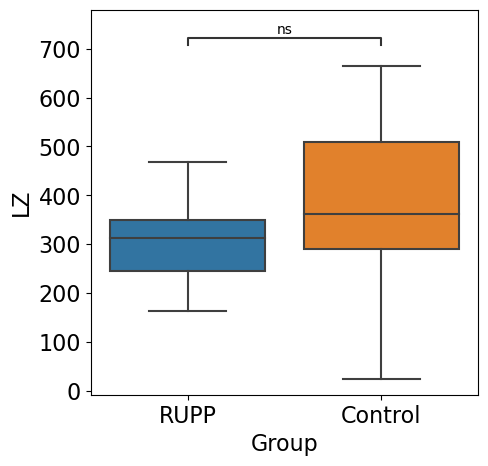

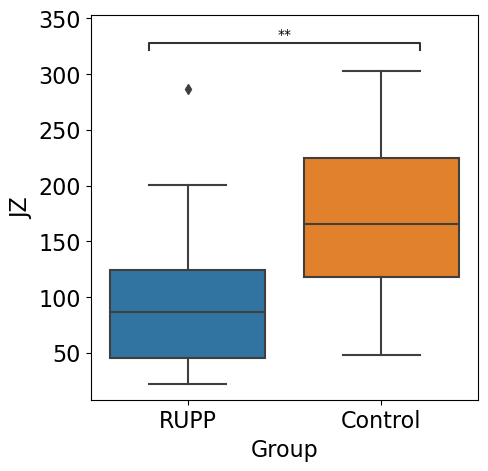

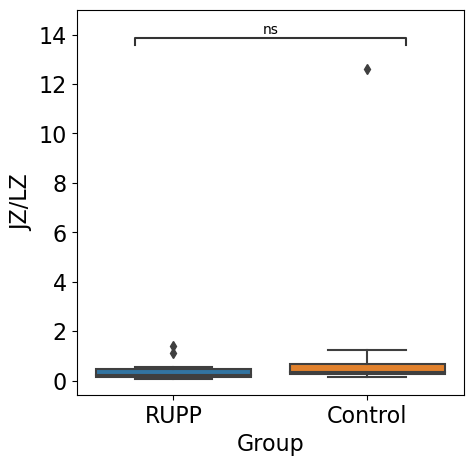

In [112]:

JZ_data = pd.DataFrame({'ID': RUPP_ids + control_ids, 'LZ': RUPP_lz + control_lz, 'JZ' : RUPP_jz + control_jz, 'JZ/LZ': RUPP_jl + control_jl})
JZ_data['Group'] = JZ_data['ID']

# Rename the Group IDs to 'Control' and 'RUPP'
JZ_data.loc[JZ_data['ID'].str[:5] == 'RTG11','Group'] = 'Control'
JZ_data.loc[JZ_data['ID'].str[:5] == 'RTG36','Group'] = 'Control'
JZ_data.loc[JZ_data['ID'].str[:5] == 'RTG37','Group'] = 'Control'
JZ_data.loc[JZ_data['ID'].str[:5] == 'RTG43','Group'] = 'Control'
JZ_data.loc[JZ_data['ID'].str[:5] == 'RTG34','Group'] = 'RUPP'
JZ_data.loc[JZ_data['ID'].str[:5] == 'RTG44','Group'] = 'RUPP'
JZ_data.loc[JZ_data['ID'].str[:5] == 'RTG46','Group'] = 'RUPP'


this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(x=JZ_data['Group'],y=JZ_data['LZ'],ax=this_ax,palette='tab10')
# sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
# this_ax.legend([],[],frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
comp_pairs = [[('Control'),('RUPP')]]
hue_plot_params = {'data':JZ_data,'x':'Group','y':'LZ','palette':'tab10'}
p_values = [0.07254]
annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
annotator.set_pvalues(p_values)
annotator.annotate()

#save_str = f'{save_folder}\\_{q_param}_boxplot.tif'
# this_fig.savefig(save_str,bbox_inches='tight',dpi=150)

this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=JZ_data,x='Group',y='JZ',ax=this_ax,palette='tab10')
# sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
# this_ax.legend([],[],frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
comp_pairs = [[('Control','Control'),('RUPP','RUPP')]]
hue_plot_params = {'data':JZ_data,'x':'Group','hue':'Group','y':'JZ','palette':'tab10'}
p_values = [0.008905]
annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
annotator.set_pvalues(p_values)
annotator.annotate()


this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=JZ_data,x='Group',y='JZ/LZ',ax=this_ax,palette='tab10')
# sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
# this_ax.legend([],[],frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
comp_pairs = [[('Control','Control'),('RUPP','RUPP')]]
hue_plot_params = {'data':JZ_data,'x':'Group','y':'JZ/LZ','hue':'Group','palette':'tab10'}
p_values = [0.2883]
annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
annotator.set_pvalues(p_values)
annotator.annotate()

0.0183384375
0.0100609375
0.0183384375
0.0100609375


C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\13254664.py:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data = in_data.groupby(['ID','Day'],as_index=False).mean()


KeyError: "['Burr b', 'Burr lambda'] not in index"

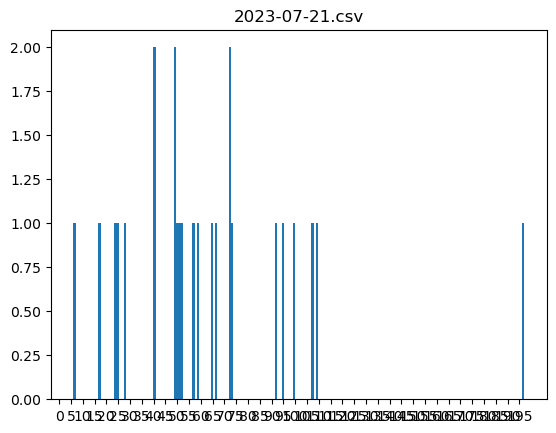

In [113]:
#Keep only placentas with at least this many ROIs
min_rois = 1

#Find the max and min depths of day 14 placentas after filtering based on min_rois
in_data_14 = in_data[in_data['Day'] == 14]
max_14 = np.nanmax(in_data_14['ZCoord'])
print(max_14)
min_14 = np.nanmin(in_data_14['ZCoord'])
print(min_14)

#Plot a histogram of the day 14 data to determine a good threshold
count_14 = in_data_14.groupby(['ID'],as_index = False).count()
count_max = np.nanmax(count_14['HK k'])
plt.hist(count_14['HK k'],bins=count_max)
plt.xticks(np.arange(0, count_max, step=5))
plt.title(data_fid)

#Find all the data with too few rois and remove
remove_idx = (count_14['HK k'] < min_rois)
count_14 = count_14.loc[remove_idx]

for count_id in count_14['ID']:
    #print(count_id)
    in_data_14.drop(in_data_14.loc[in_data_14['ID'] == count_id].index,inplace=True)
    print(in_data_14.size)

max_14 = np.nanmax(in_data_14['ZCoord'])
print(max_14)
min_14 = np.nanmin(in_data_14['ZCoord'])
print(min_14)

#Keep only the coordinates within the range of depths of day 14 placentas
remove_idx = (in_data['ZCoord'] > max_14) | (in_data['ZCoord'] < min_14)

# Keep only the rows where the ROI was 13mm +/- 1mm in z-direction
# ZCoord specifies to top of the ROI. And the ROI z-length is 0.5mm
#remove_idx = (in_data['ZCoord'] > .0155) | (in_data['ZCoord'] < .0115)
# remove_idx = (in_data['ZCoord'] > .0125) | (in_data['ZCoord'] < .0115)
in_data.drop(in_data.loc[remove_idx].index,inplace=True)

#Sum data after the removal of IDs out of the focal range
sum_data_range = in_data.groupby(['ID','Day'],as_index=False).count()

# The .csv contains a row for every ROI within the placenta boundaries in each frame.
# Compute the mean of the QUS parameters within each placenta
mean_data = in_data.groupby(['ID','Day'],as_index=False).mean()
std_data = in_data.groupby(['ID','Day'],as_index=False).std()
std_data = std_data[['ID','Day'] + qus_params]

# Drop the cases where too few ROIs are in the target range
#Currently unused
count_df = in_data.groupby(['ID','Day'],as_index=False).count()
keep_ids = (count_df['HK k'] >= min_rois)
count_df = count_df.loc[keep_ids]
mean_data = pd.merge(left=mean_data,right=count_df[['ID','Day']],how='inner',on=['ID','Day'])
sum_data = pd.merge(left=sum_data,right=count_df[['ID','Day']],how='inner',on=['ID','Day'])
sum_data_range = pd.merge(left=sum_data_range,right=count_df[['ID','Day']],how='inner',on=['ID','Day'])

# Testing day 14 coordinates
#in_data_group = in_data.groupby(['ID','Day'],as_index=False)
#range_group = in_data_group.loc.agg([np.max,np.min])
#print(range_group['ZCoord'])

# All QUS parameters - this list will make life easier later
qus_params_std = [f'{qq}_std' for qq in qus_params]
std_rename = {f'{qq}':f'{qq}_std' for qq in qus_params} 
std_data.rename(std_rename,axis=1,inplace=True)

#Add std deviation to mean data frame
mean_data = pd.merge(left=mean_data,right=std_data,how='inner',on=['ID','Day'])


# Keep only the first 5 characters from the ID - the last specifies placenta (not animal) and is not needed at this time
# This will make it easier to separate the control and treat groups
mean_data['Pnum'] = mean_data['ID'].str[5:].astype(int)
mean_data['ID'] = mean_data['ID'].str[:5]

# Create a "Group" column to specify Control and RUPP animals
mean_data['Group'] = mean_data['ID']

# Rename the Group IDs to 'Control' and 'RUPP'
mean_data.loc[mean_data['ID'] == 'RTG11','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG36','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG37','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG43','Group'] = 'Control'
mean_data.loc[mean_data['ID'] == 'RTG34','Group'] = 'RUPP'
mean_data.loc[mean_data['ID'] == 'RTG44','Group'] = 'RUPP'
mean_data.loc[mean_data['ID'] == 'RTG46','Group'] = 'RUPP'



In [ ]:

sum_data.groupby('Day').mean()

C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\3107667228.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_data.groupby('Day').mean()


HK k  HK alpha    Naka m  Naka Omega        SS        I0       MBF  \
Day                                                                           
14    63.8400   63.8400   63.8400     63.8400   63.8400   63.8400   63.8400   
18   430.8125  430.8125  430.8125    430.8125  430.8125  430.8125  430.8125   

          ESD       EAC  ROI Z Dist    XCoord    YCoord    ZCoord     Frame  
Day                                                                          
14    63.8400   63.8400     63.8400   63.8400   63.8400   63.8400   63.8400  
18   430.8125  430.8125    430.8125  430.8125  430.8125  430.8125  430.8125

In [ ]:
sum_data.groupby('Day').count()

ID  HK k  HK alpha  Naka m  Naka Omega  SS  I0  MBF  ESD  EAC  \
Day                                                                  
14   25    25        25      25          25  25  25   25   25   25   
18   32    32        32      32          32  32  32   32   32   32   

     ROI Z Dist  XCoord  YCoord  ZCoord  Frame  
Day                                             
14           25      25      25      25     25  
18           32      32      32      32     32

In [ ]:

sum_data_range.groupby('Day').mean()


C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\888916769.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_data_range.groupby('Day').mean()


HK k  HK alpha    Naka m  Naka Omega        SS        I0       MBF  \
Day                                                                           
14    63.8400   63.8400   63.8400     63.8400   63.8400   63.8400   63.8400   
18   379.9375  379.9375  379.9375    379.9375  379.9375  379.9375  379.9375   

          ESD       EAC  ROI Z Dist    XCoord    YCoord    ZCoord     Frame  \
Day                                                                           
14    63.8400   63.8400     63.8400   63.8400   63.8400   63.8400   63.8400   
18   379.9375  379.9375    379.9375  379.9375  379.9375  379.9375  379.9375   

        Group  
Day            
14    63.8400  
18   379.9375

In [ ]:
#with pd.ExcelWriter(r'C:\Users\acm4005\Box\WCM_Tulane_Shared_Folder\Preeclampsia Model\_ROI_sums.xlsx') as writer:
#     sum_data.to_excel(writer)
sum_data_range.groupby('Day').count()

ID  HK k  HK alpha  Naka m  Naka Omega  SS  I0  MBF  ESD  EAC  \
Day                                                                  
14   25    25        25      25          25  25  25   25   25   25   
18   32    32        32      32          32  32  32   32   32   32   

     ROI Z Dist  XCoord  YCoord  ZCoord  Frame  Group  
Day                                                    
14           25      25      25      25     25     25  
18           32      32      32      32     32     32

In [ ]:
#Import information about the orientation of the placenta and merge with mean data
p_orient = pd.read_csv("Placenta Orientation.csv")
p_data = pd.merge(left = p_orient, right = mean_data, how = 'inner',on = ['ID','Day','Pnum'])
#Remove data where the placenta is under the fetus
#mean_data = p_data.loc[p_data['Side Under'] != 1]
#mean_data


In [ ]:
keep_params = ['ID','Group','Day','Pnum'] + qus_params + [f'{qq}_std' for qq in qus_params]
summary_df = mean_data[keep_params]

save_str = r'.\_result_summary_by_placenta.xlsx'
# with pd.ExcelWriter(save_str,engine_kwargs={'options':{'strings_to_numbers':True}}) as writer:
#     summary_df.to_excel(writer)

In [ ]:
mean_data.groupby(['ID','Day']).count()

HK k  HK alpha  Naka m  Naka Omega  SS  I0  MBF  ESD  EAC  \
ID    Day                                                              
RTG34 14      5         5       5           5   5   5    5    5    5   
      18      5         5       5           5   5   5    5    5    5   
RTG36 14      4         4       4           4   4   4    4    4    4   
      18      5         5       5           5   5   5    5    5    5   
RTG37 14      4         4       4           4   4   4    4    4    4   
      18      5         5       5           5   5   5    5    5    5   
RTG43 14      2         2       2           2   2   2    2    2    2   
      18      6         6       6           6   6   6    6    6    6   
RTG44 14      5         5       5           5   5   5    5    5    5   
      18      6         6       6           6   6   6    6    6    6   
RTG46 14      5         5       5           5   5   5    5    5    5   
      18      5         5       5           5   5   5    5    5    5   

           ROI Z Dist  ...  EAC_std  MBF_std  SS_std  I0_std  Naka Omega_std  \
ID    Day              ...                                                     
RTG34 14            5  ...        5        5       5       5               5   
      18            5  ...        5        5       5       5               5   
RTG36 14            4  ...        4        4       4       4               4   
      18            5  ...        5        5       5       5               5   
RTG37 14            4  ...        4        4       4       4               4   
      18            5  ...        5        5       5       5               5   
RTG43 14            2  ...        2        2       2       2               2   
      18            6  ...        6        6       6       6               6   
RTG44 14            5  ...        5        5       5       5               5   
      18            6  ...        6        6       6       6               6   
RTG46 14            5  ...        5        5       5       5               5   
      18            5  ...        5        5       5       5               5   

           Naka m_std  HK k_std  HK alpha_std  Pnum  Group  
ID    Day                                                   
RTG34 14            5         5             5     5      5  
      18            5         5             5     5      5  
RTG36 14            4         4             4     4      4  
      18            5         5             5     5      5  
RTG37 14            4         4             4     4      4  
      18            5         5             5     5      5  
RTG43 14            2         2             2     2      2  
      18            6         6             6     6      6  
RTG44 14            5         5             5     5      5  
      18            6         6             6     6      6  
RTG46 14            5         5             5     5      5  
      18            5         5             5     5      5  

[12 rows x 24 columns]

In [ ]:
dd = mean_data.copy()
dd = dd[dd['Day'] == 18]
dd.groupby(['Group']).count()

#Redundant removal, why is this here?
#in_data.drop(in_data.loc[remove_idx].index,inplace=True)

ID  Day  HK k  HK alpha  Naka m  Naka Omega  SS  I0  MBF  ESD  ...  \
Group                                                                   ...   
Control  16   16    16        16      16          16  16  16   16   16  ...   
RUPP     16   16    16        16      16          16  16  16   16   16  ...   

         ESD_std  EAC_std  MBF_std  SS_std  I0_std  Naka Omega_std  \
Group                                                                
Control       16       16       16      16      16              16   
RUPP          16       16       16      16      16              16   

         Naka m_std  HK k_std  HK alpha_std  Pnum  
Group                                              
Control          16        16            16    16  
RUPP             16        16            16    16  

[2 rows x 25 columns]

In [ ]:
p_stats = mean_data.groupby(['Group','Day']).agg([np.mean,np.std])
p_stats['EAC']

C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\2915751020.py:1: FutureWarning: ['ID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  p_stats = mean_data.groupby(['Group','Day']).agg([np.mean,np.std])


mean       std
Group   Day                      
Control 14   116.023285  2.552412
        18   117.972441  3.765786
RUPP    14   117.086081  5.080553
        18   118.732364  3.501675

In [ ]:
# Take the average of the placentas for each animal
p_avg = mean_data.groupby(['ID','Day'], as_index=False).mean()

p_avg

C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\855106950.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p_avg = mean_data.groupby(['ID','Day'], as_index=False).mean()


ID  Day      HK k  HK alpha    Naka m  Naka Omega        SS         I0  \
0   RTG34   14  0.225951  0.646628  0.907096    6.212276 -0.180616  19.798489   
1   RTG34   18  0.192300  0.866811  0.913468    6.043166  0.434689  11.829517   
2   RTG36   14  0.242387  0.845475  0.934213    6.210795  0.030951  18.364581   
3   RTG36   18  0.257062  0.991983  0.957807    6.337238  0.341204  16.419441   
4   RTG37   14  0.184872  0.940428  0.934797    6.125267  0.025665  18.229575   
5   RTG37   18  0.217337  0.931998  0.932383    6.003082  0.318531  13.420757   
6   RTG43   14  0.138417  0.865037  0.896724    6.195633  0.179601  15.906823   
7   RTG43   18  0.222156  0.841992  0.923058    6.154581  0.082907  17.202302   
8   RTG44   14  0.165902  0.744287  0.888125    6.344556 -0.086871  20.162995   
9   RTG44   18  0.232683  0.886930  0.931759    6.047790  0.369817  12.862837   
10  RTG46   14  0.245292  0.703990  0.909371    6.370234  0.180634  19.536926   
11  RTG46   18  0.206729  0.840877  0.916400    6.077162  0.434008  13.253488   

          MBF        ESD  ...   ESD_std   EAC_std   MBF_std    SS_std  \
0   17.269860  29.172408  ...  3.518988  1.985488  1.933153  0.341434   
1   17.915167  21.759603  ...  5.149736  7.400926  3.034786  0.349189   
2   18.797895  26.789712  ...  3.716754  3.620215  2.418814  0.324032   
3   21.196297  23.110352  ...  5.171252  5.682764  2.818921  0.378441   
4   18.588886  27.000798  ...  3.369481  3.186791  2.227666  0.297195   
5   17.880190  23.454267  ...  4.856503  5.367344  3.425258  0.364921   
6   18.421234  25.460403  ...  3.276317  2.387911  1.979414  0.268928   
7   18.363001  26.188466  ...  4.398529  4.305519  3.177699  0.374034   
8   18.946799  28.138098  ...  3.237845  2.124581  1.849044  0.298160   
9   18.040279  22.822182  ...  4.744305  5.908771  3.664474  0.348220   
10  22.065796  24.694624  ...  4.343518  4.893928  2.012715  0.327775   
11  19.329601  21.884144  ...  4.869624  5.534309  2.993180  0.345663   

      I0_std  Naka Omega_std  Naka m_std  HK k_std  HK alpha_std  Pnum  
0   5.720353        0.195057    0.094963  0.226480      0.354243   3.0  
1   5.311045        0.266454    0.100148  0.220557      0.510384   3.0  
2   4.121955        0.109400    0.100442  0.265762      0.515707   2.5  
3   5.826710        0.260340    0.091172  0.259319      0.516725   3.0  
4   3.860044        0.106147    0.082485  0.222030      0.477264   2.5  
5   6.382267        0.264697    0.098555  0.243195      0.537284   3.0  
6   4.531600        0.159203    0.094452  0.201067      0.519435   1.5  
7   6.246784        0.230427    0.102765  0.238104      0.510601   3.5  
8   4.981250        0.167189    0.093850  0.195218      0.432557   3.0  
9   5.982546        0.223208    0.104012  0.246746      0.535920   3.5  
10  4.580657        0.134340    0.108803  0.240167      0.436831   3.0  
11  6.050716        0.251544    0.105942  0.235146      0.493006   3.0  

[12 rows x 25 columns]

In [ ]:
# Need to regroup the animals after averaging process because python can't take the average of a string.
p_avg['Group'] = p_avg['ID']

p_avg.loc[p_avg['ID'] == 'RTG11','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG36','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG37','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG43','Group'] = 'Control'
p_avg.loc[p_avg['ID'] == 'RTG34','Group'] = 'RUPP'
p_avg.loc[p_avg['ID'] == 'RTG44','Group'] = 'RUPP'
p_avg.loc[p_avg['ID'] == 'RTG46','Group'] = 'RUPP'

# Compute average and standard deviation across groups of animals
a_stats = p_avg.groupby(['Group','Day'],as_index=False).agg([np.mean,np.std])
a_stats['EAC']

C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\4003448711.py:13: FutureWarning: ['ID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  a_stats = p_avg.groupby(['Group','Day'],as_index=False).agg([np.mean,np.std])


mean       std
Group   Day                      
Control 14   116.022184  0.258639
        18   118.080550  2.323694
RUPP    14   117.086081  3.816548
        18   118.802041  1.060169

<Axes: xlabel='EAC', ylabel='ESD'>

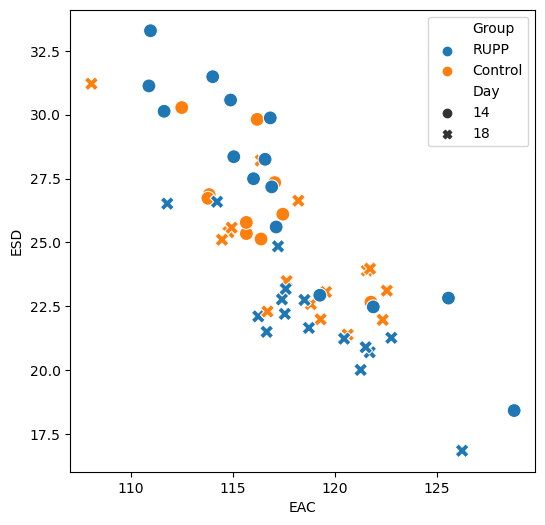

In [ ]:
this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=mean_data,x='EAC',y='ESD',hue='Group',style='Day',s=100)

<Axes: xlabel='ID', ylabel='ESD'>

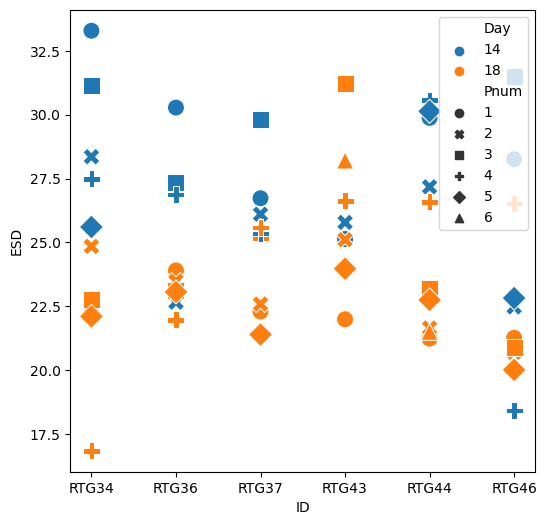

In [ ]:
this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(data=mean_data,x='ID',y='ESD',hue='Day',style='Pnum',ax=this_ax,s=150,palette='tab10')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18_RUPP vs. 18_Control: Custom statistical test, P_val:1.200e-02
14_RUPP vs. 14_Control: Custom statistical test, P_val:1.860e-01
14_Control vs. 18_Control: Custom statistical test, P_val:5.000e-03
14_RUPP vs. 18_RUPP: Custom statistical test, P_val:8.280e-01


(array([15., 20., 25., 30., 35., 40.]),
 [Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40')])

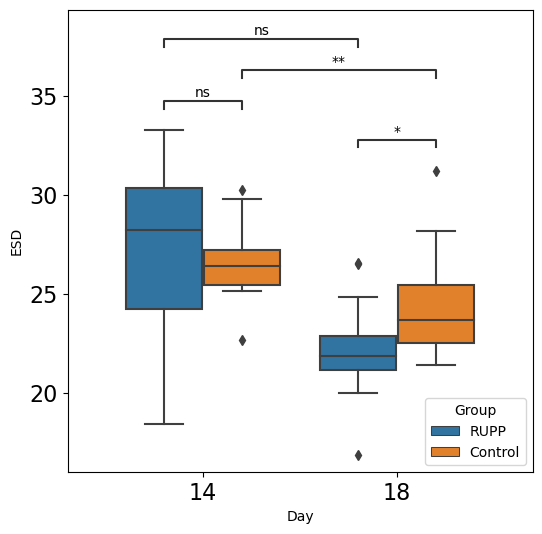

In [ ]:
esd_df = mean_data[['Group','Day','ESD']]
comp_pairs = [[(14,'Control'),(14,'RUPP')],
              [(18,'Control'),(18,'RUPP')],
              [(14,'Control'),(18,'Control')],
              [(14,'RUPP'),(18,'RUPP')]]

p_values = [0.186, 0.012,0.005,0.828]

this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

hue_plot_params = {'data':esd_df,'x':'Day','y':'ESD','hue':'Group','palette':'tab10'}

sns.boxplot(ax=this_ax,**hue_plot_params)
annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
annotator.set_pvalues(p_values)
annotator.annotate()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# this_fig.savefig(r'.\boxplot_esd_with_bars.tif',bbox_inches='tight',dpi=150)

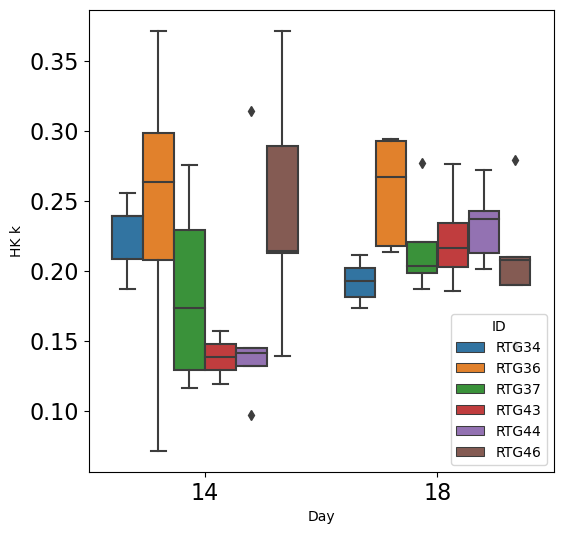

In [ ]:
hkk_df = mean_data[['ID','Day','HK k']]
comp_pairs = [[(14,'Control'),(14,'RUPP')],
              [(18,'Control'),(18,'RUPP')],
              [(14,'Control'),(18,'Control')],
              [(14,'RUPP'),(18,'RUPP')]]

this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

hue_plot_params = {'data':hkk_df,'x':'Day','y':'HK k','hue':'ID','palette':'tab10'}

sns.boxplot(ax=this_ax,**hue_plot_params)
#annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
#annotator.set_pvalues(p_values)
#annotator.annotate()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

this_fig.savefig(r'.\boxplot_HKk_with_bars.tif',bbox_inches='tight',dpi=150)

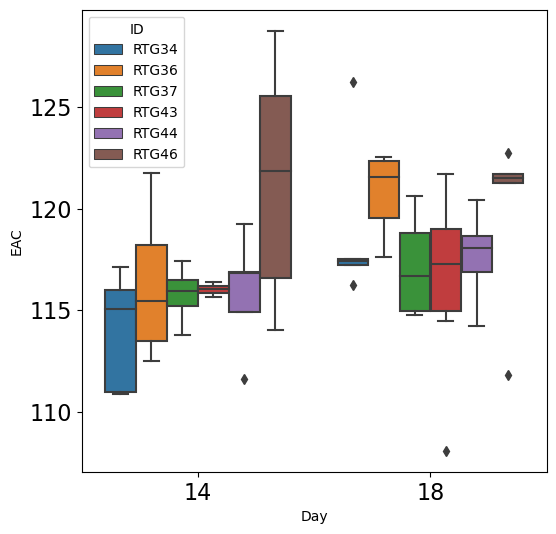

In [ ]:
eac_df = mean_data[['ID','Day','EAC']]
comp_pairs = [[(14,'Control'),(14,'RUPP')],
              [(18,'Control'),(18,'RUPP')],
              [(14,'Control'),(18,'Control')],
              [(14,'RUPP'),(18,'RUPP')]]

p_values = [0.186, 0.012,0.005,0.828]

this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

hue_plot_params = {'data':eac_df,'x':'Day','y':'EAC','hue':'ID','palette':'tab10'}

sns.boxplot(ax=this_ax,**hue_plot_params)
#annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
#annotator.set_pvalues(p_values)
#annotator.annotate()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

this_fig.savefig(r'.\boxplot_eac_with_bars.tif',bbox_inches='tight',dpi=150)

In [ ]:
mean_data.groupby(['ID','Day']).count()

HK k  HK alpha  Naka m  Naka Omega  SS  I0  MBF  ESD  EAC  \
ID    Day                                                              
RTG34 14      5         5       5           5   5   5    5    5    5   
      18      5         5       5           5   5   5    5    5    5   
RTG36 14      4         4       4           4   4   4    4    4    4   
      18      5         5       5           5   5   5    5    5    5   
RTG37 14      4         4       4           4   4   4    4    4    4   
      18      5         5       5           5   5   5    5    5    5   
RTG43 14      2         2       2           2   2   2    2    2    2   
      18      6         6       6           6   6   6    6    6    6   
RTG44 14      5         5       5           5   5   5    5    5    5   
      18      6         6       6           6   6   6    6    6    6   
RTG46 14      5         5       5           5   5   5    5    5    5   
      18      5         5       5           5   5   5    5    5    5   

           ROI Z Dist  ...  EAC_std  MBF_std  SS_std  I0_std  Naka Omega_std  \
ID    Day              ...                                                     
RTG34 14            5  ...        5        5       5       5               5   
      18            5  ...        5        5       5       5               5   
RTG36 14            4  ...        4        4       4       4               4   
      18            5  ...        5        5       5       5               5   
RTG37 14            4  ...        4        4       4       4               4   
      18            5  ...        5        5       5       5               5   
RTG43 14            2  ...        2        2       2       2               2   
      18            6  ...        6        6       6       6               6   
RTG44 14            5  ...        5        5       5       5               5   
      18            6  ...        6        6       6       6               6   
RTG46 14            5  ...        5        5       5       5               5   
      18            5  ...        5        5       5       5               5   

           Naka m_std  HK k_std  HK alpha_std  Pnum  Group  
ID    Day                                                   
RTG34 14            5         5             5     5      5  
      18            5         5             5     5      5  
RTG36 14            4         4             4     4      4  
      18            5         5             5     5      5  
RTG37 14            4         4             4     4      4  
      18            5         5             5     5      5  
RTG43 14            2         2             2     2      2  
      18            6         6             6     6      6  
RTG44 14            5         5             5     5      5  
      18            6         6             6     6      6  
RTG46 14            5         5             5     5      5  
      18            5         5             5     5      5  

[12 rows x 24 columns]

In [ ]:
in_data.groupby(['ID','Day']).count()

HK k  HK alpha  Naka m  Naka Omega   SS   I0  MBF  ESD  EAC  \
ID     Day                                                                
RTG341 14     73        73      73          73   73   73   73   73   73   
       18    300       300     300         300  300  300  300  300  300   
RTG342 14     40        40      40          40   40   40   40   40   40   
       18    280       280     280         280  280  280  280  280  280   
RTG343 14    107       107     107         107  107  107  107  107  107   
       18    294       294     294         294  294  294  294  294  294   
RTG344 14     52        52      52          52   52   52   52   52   52   
       18    293       293     293         293  293  293  293  293  293   
RTG345 14     25        25      25          25   25   25   25   25   25   
       18    243       243     243         243  243  243  243  243  243   
RTG361 14     59        59      59          59   59   59   59   59   59   
       18    505       505     505         505  505  505  505  505  505   
RTG362 14     92        92      92          92   92   92   92   92   92   
       18    829       829     829         829  829  829  829  829  829   
RTG363 14    109       109     109         109  109  109  109  109  109   
       18    486       486     486         486  486  486  486  486  486   
RTG364 14     50        50      50          50   50   50   50   50   50   
       18    556       556     556         556  556  556  556  556  556   
RTG365 18    468       468     468         468  468  468  468  468  468   
RTG371 14     17        17      17          17   17   17   17   17   17   
       18    315       315     315         315  315  315  315  315  315   
RTG372 14     67        67      67          67   67   67   67   67   67   
       18    476       476     476         476  476  476  476  476  476   
RTG373 14     57        57      57          57   57   57   57   57   57   
       18    364       364     364         364  364  364  364  364  364   
RTG374 14     24        24      24          24   24   24   24   24   24   
       18    558       558     558         558  558  558  558  558  558   
RTG375 18    395       395     395         395  395  395  395  395  395   
RTG431 14     72        72      72          72   72   72   72   72   72   
       18    501       501     501         501  501  501  501  501  501   
RTG432 14    100       100     100         100  100  100  100  100  100   
       18    228       228     228         228  228  228  228  228  228   
RTG433 18    244       244     244         244  244  244  244  244  244   
RTG434 18    338       338     338         338  338  338  338  338  338   
RTG435 18    406       406     406         406  406  406  406  406  406   
RTG436 18    348       348     348         348  348  348  348  348  348   
RTG441 14     72        72      72          72   72   72   72   72   72   
       18    396       396     396         396  396  396  396  396  396   
RTG442 14     28        28      28          28   28   28   28   28   28   
       18    380       380     380         380  380  380  380  380  380   
RTG443 14     51        51      51          51   51   51   51   51   51   
       18    378       378     378         378  378  378  378  378  378   
RTG444 14     95        95      95          95   95   95   95   95   95   
       18    381       381     381         381  381  381  381  381  381   
RTG445 14    197       197     197         197  197  197  197  197  197   
       18    164       164     164         164  164  164  164  164  164   
RTG446 18    339       339     339         339  339  339  339  339  339   
RTG461 14     49        49      49          49   49   49   49   49   49   
       18    450       450     450         450  450  450  450  450  450   
RTG462 14      6         6       6           6    6    6    6    6    6   
       18    350       350     350         350  350  350  350  350  350   
RTG463 14     49        49      49   

In [ ]:
mean_data.groupby(['ID']).agg([np.max, np.min])['ZCoord']

amax      amin
ID                       
RTG34  0.015909  0.012261
RTG36  0.015914  0.012052
RTG37  0.016306  0.012153
RTG43  0.015652  0.012588
RTG44  0.015815  0.010541
RTG46  0.016162  0.013804

In [ ]:
# Compute the independent samples t-test between placentas on days 14 and 18
# Also add the difference in the mean parameters values as day_18 - day_14
ttest_res = np.zeros((len(qus_params),3)) # numpy array to store the t-statistics and p-values
d14_df = mean_data[mean_data['Day'] == 14]
d18_df = mean_data[mean_data['Day'] == 18]

for q_idx, q_param in enumerate(qus_params):
    var_1 = d14_df[q_param]
    var_2 = d18_df[q_param]

    var_diff = np.mean(var_2) - np.mean(var_1)

    t_stat, p_value = scipy.stats.ttest_ind(var_1.values.reshape(-1,1),var_2.values.reshape(-1,1))

    ttest_res[q_idx] = [t_stat,p_value,var_diff]

ttest_df = pd.DataFrame(ttest_res,index=qus_params,columns=['t_val','p-value','Diff. of Means'])
# ttest_df.to_excel(r'.\_ttest_results_by_day_2023-3-29.xlsx')

save_str = r'.\_ttest_results_by_day_2023-3-29.xlsx'
# with pd.ExcelWriter(save_str,engine_kwargs={'options':{'strings_to_numbers':True}}) as writer:
#     ttest_df.to_excel(writer)

print(ttest_df)

               t_val       p-value  Diff. of Means
ESD         4.612349  2.419928e-05       -3.759786
EAC        -1.633125  1.081553e-01        1.691439
MBF         0.534240  5.953281e-01       -0.361263
SS         -4.657285  2.070352e-05        0.317648
I0          6.225421  6.940656e-08       -4.808329
Naka Omega  2.915342  5.131405e-03       -0.144913
Naka m     -1.865242  6.748534e-02        0.017339
HK k       -0.917730  3.627670e-01        0.014892
HK alpha   -3.033986  3.680317e-03        0.117692


C:\Users\acm4005\AppData\Local\Temp\ipykernel_15996\1638869288.py:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  ttest_res[q_idx] = [t_stat,p_value,var_diff]


In [ ]:
df_list = []

test_df = mean_data[mean_data['Group'] == 'Control']
save_str = r'_paired_t-test_control_2023-3-29.xlsx'

# test_df = mean_data[mean_data['Group'] == 'RUPP']
# save_str = r'_paired_t-test_RUPP_2023_3_29.xlsx'


for q_idx, qp in enumerate(qus_params):

    this_tukey = pairwise_tukeyhsd(endog=test_df[qp],groups=test_df['Day'],alpha=0.05)
    this_data = this_tukey._results_table.data

    this_data = np.asarray(this_data)
    this_data = this_data[1:,:]

    # Create a list of tuples to act as a MultiIndex specifying the two Diagnosis groups being compared
    col_1 = this_data[:,0].tolist()
    col_2 = this_data[:,1].tolist()
    m_ind = m_ind = list(zip(col_1,col_2))
    m_ind = pd.MultiIndex.from_tuples(m_ind,names=['Group 1','Group 2'])
    this_series = pd.Series(this_data[:,3],index=m_ind,name=qp)

    df_list.append(this_series.copy())

master_df = pd.concat(df_list,axis=1)
master_df.reset_index(inplace=True)

print(master_df)

# with pd.ExcelWriter(save_str,engine_kwargs={'options':{'strings_to_numbers':True}}) as writer:
#     master_df.to_excel(writer)

  Group 1 Group 2     ESD     EAC     MBF      SS     I0 Naka Omega  Naka m  \
0      14      18  0.0341  0.1633  0.6549  0.0497  0.074     0.9074  0.3522   

    HK k HK alpha  
0  0.219   0.4948  


In [ ]:
master_df.head()

Group 1 Group 2     ESD     EAC     MBF      SS     I0 Naka Omega  Naka m  \
0      14      18  0.0341  0.1633  0.6549  0.0497  0.074     0.9074  0.3522   

    HK k HK alpha  
0  0.219   0.4948

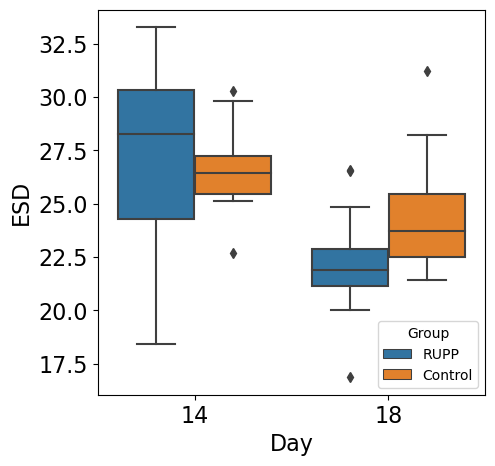

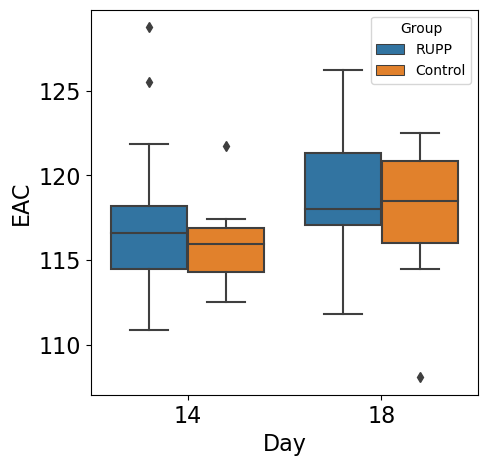

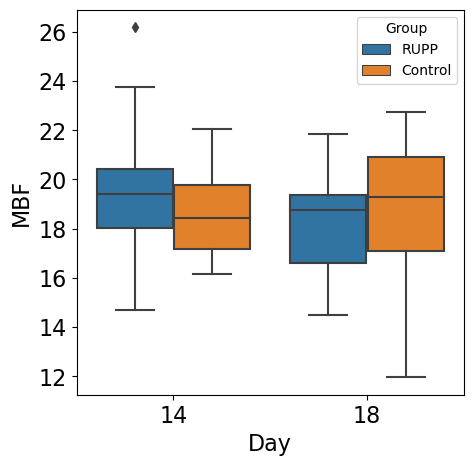

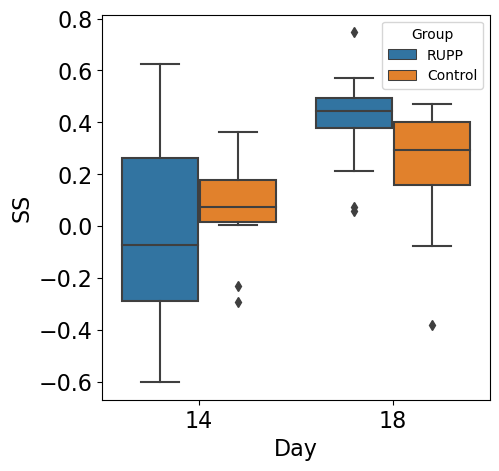

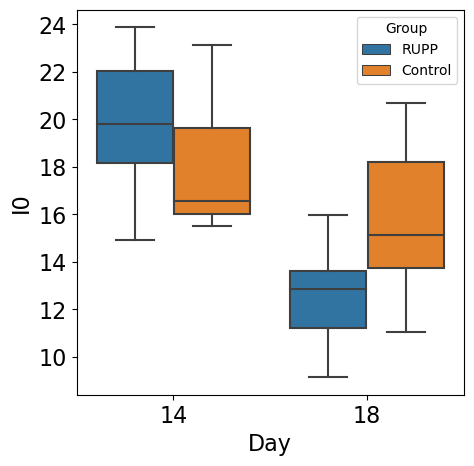

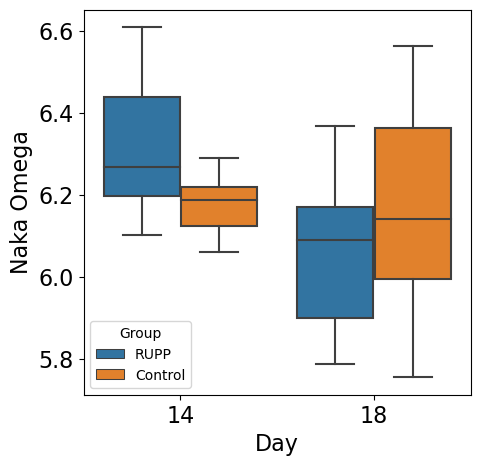

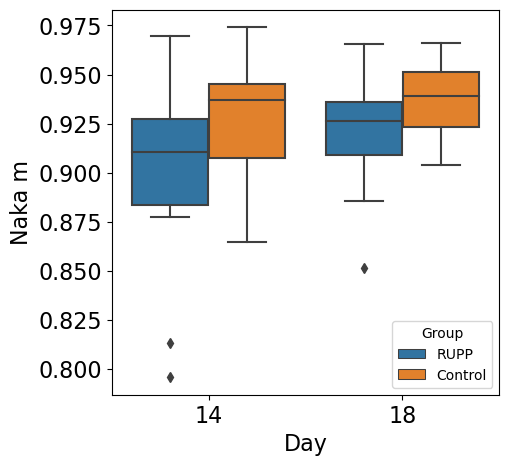

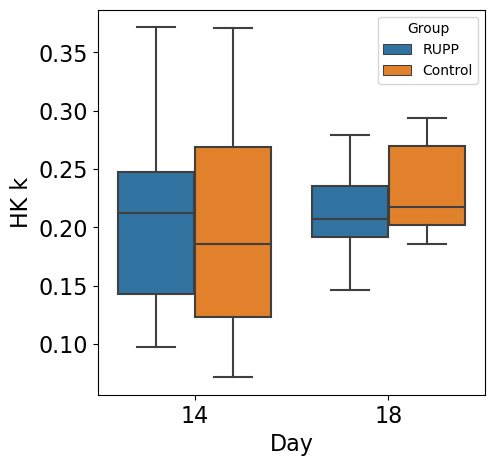

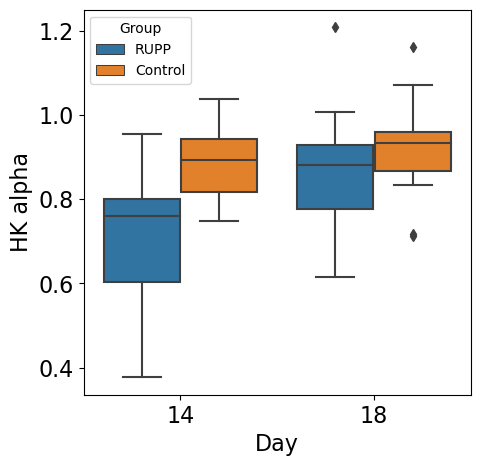

In [ ]:
# Create box plots comparing the (mean) QUS parameters for all 3 days

save_folder = r'.\Boxplots_Mean_2023-3-29'

# if ~os.path.exists(save_folder):
    # os.mkdir(save_folder)

for q_idx, q_param in enumerate(qus_params):
    this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

    sns.boxplot(data=mean_data,x='Day',hue='Group',y=q_param,ax=this_ax,palette='tab10')
    # sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    save_str = f'{save_folder}\\_{q_param}_boxplot.tif'
    # this_fig.savefig(save_str,bbox_inches='tight',dpi=150)

    

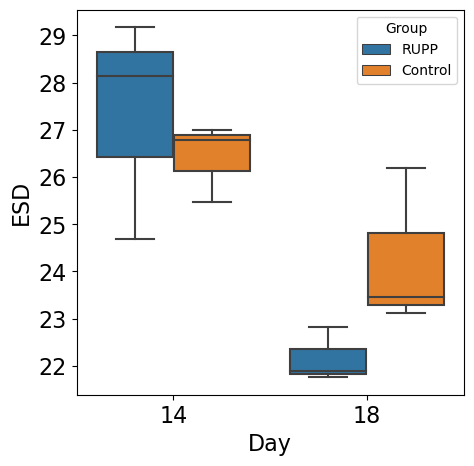

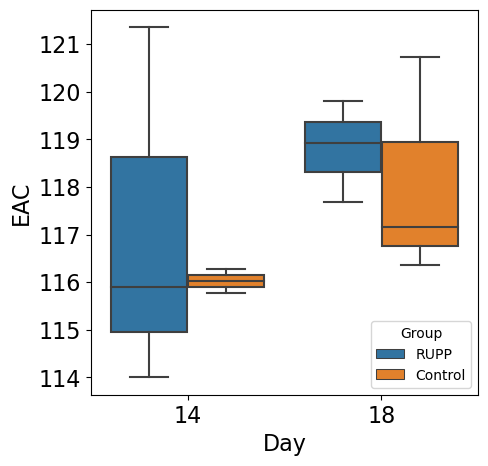

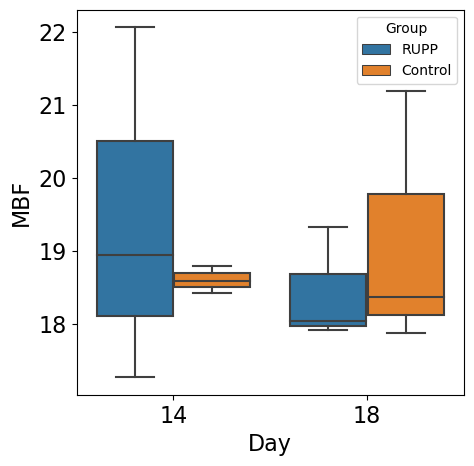

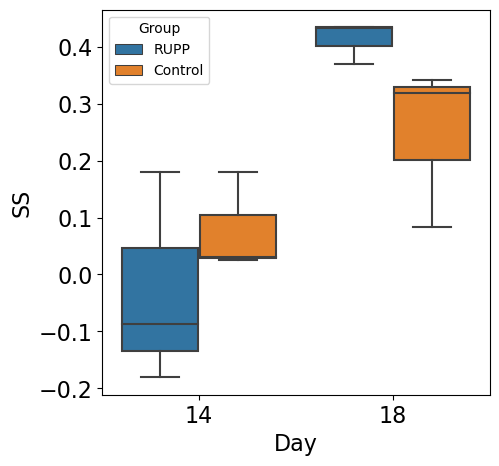

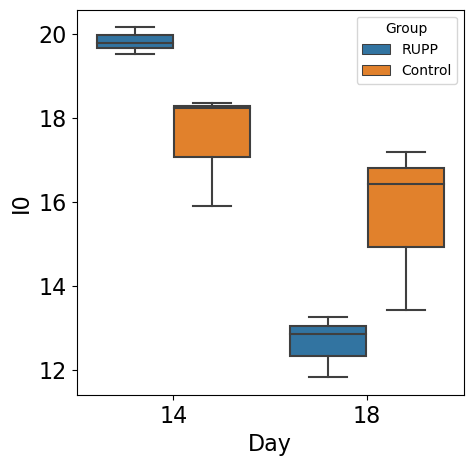

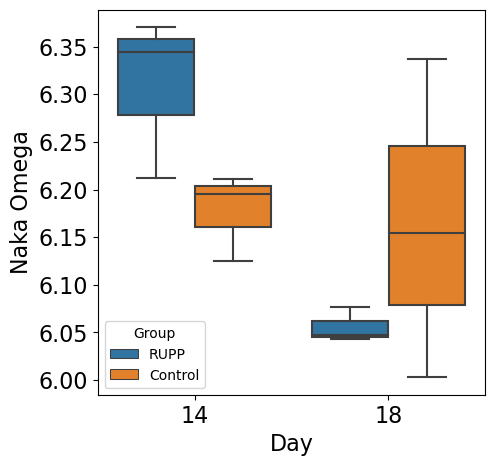

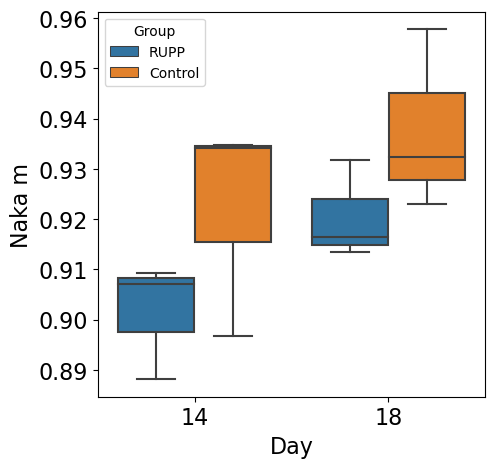

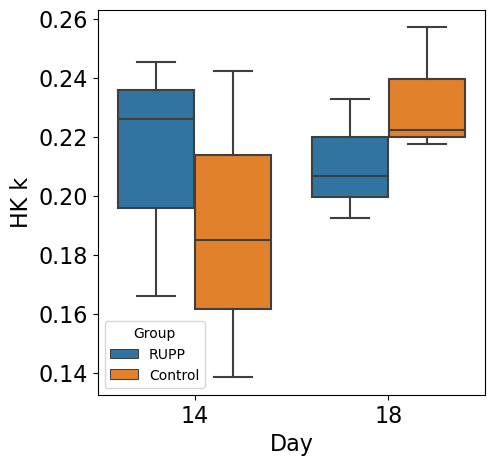

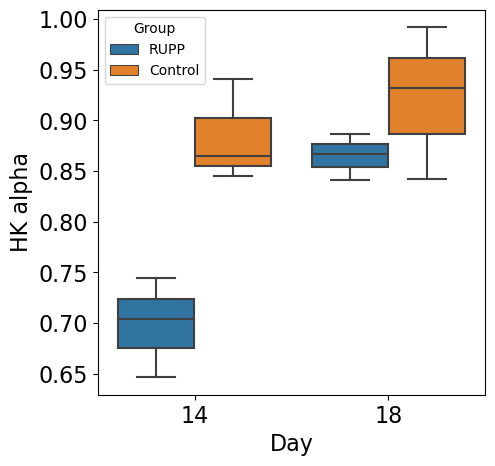

In [ ]:
# Create box plots comparing the (mean) QUS parameters for all 3 days

save_folder = r'.\Boxplots_Mean_2023-3-29'

# if ~os.path.exists(save_folder):
    # os.mkdir(save_folder)

for q_idx, q_param in enumerate(qus_params):
    this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

    sns.boxplot(data=p_avg,x='Day',hue='Group',y=q_param,ax=this_ax,palette='tab10')
    # sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    save_str = f'{save_folder}\\_{q_param}_boxplot.tif'
    # this_fig.savefig(save_str,bbox_inches='tight',dpi=150)


In [ ]:
os.path.exists(save_folder)

True

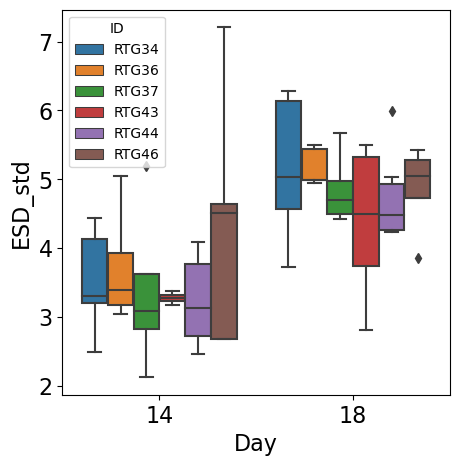

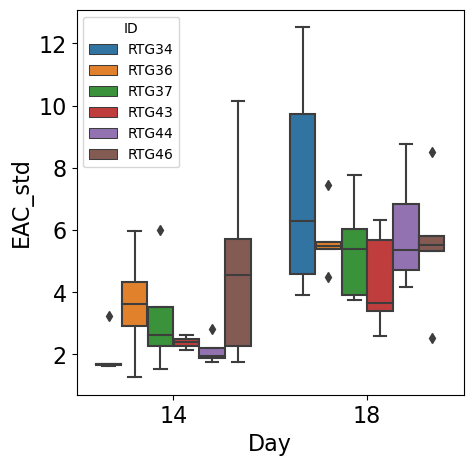

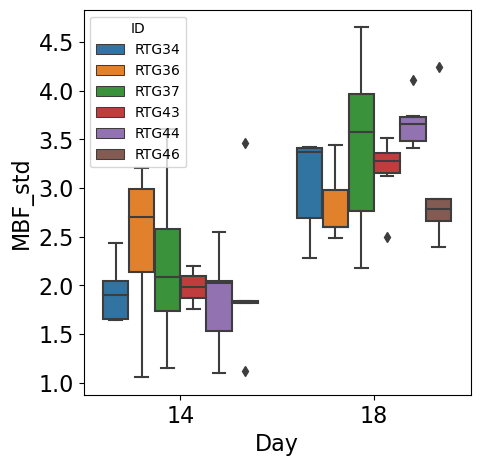

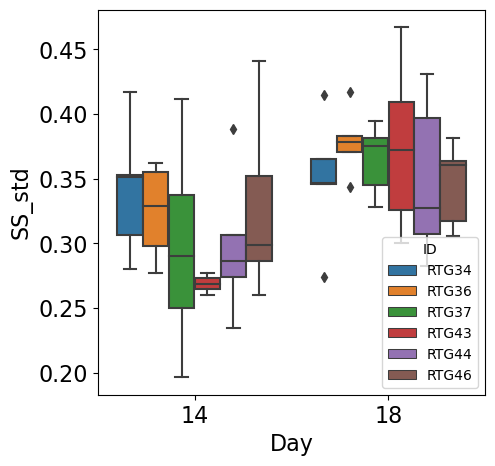

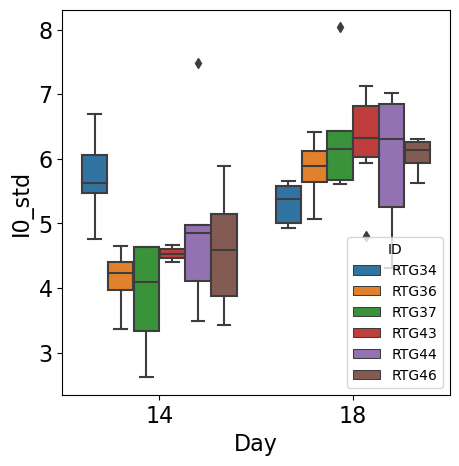

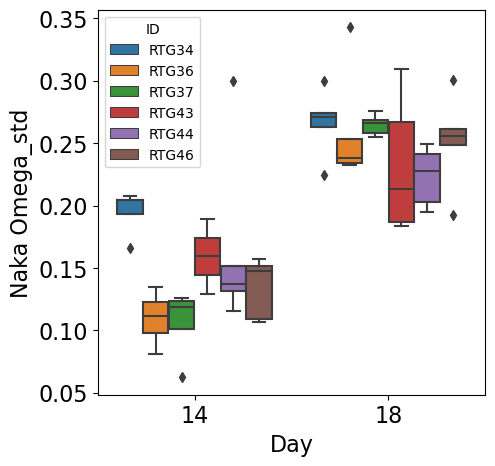

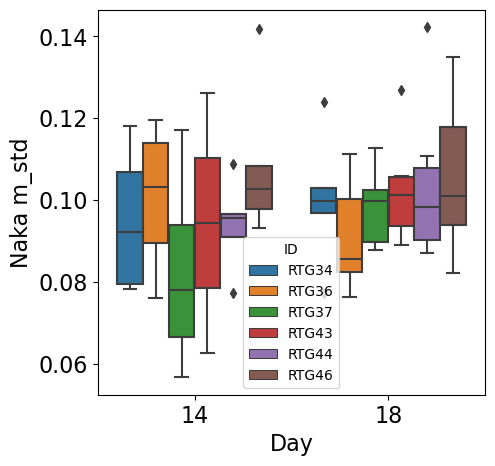

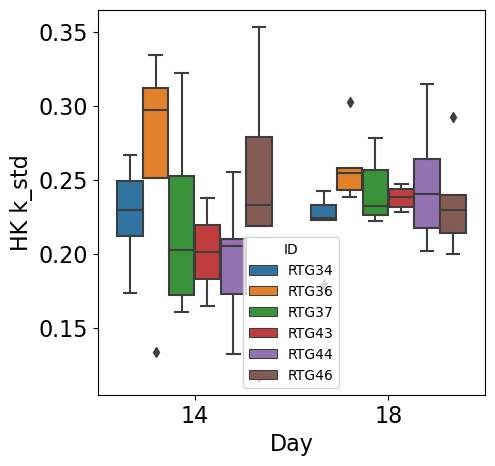

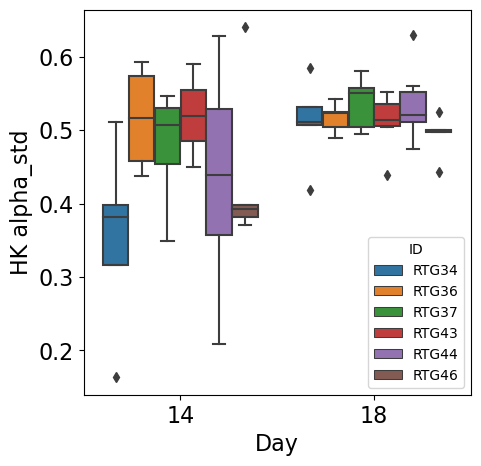

In [ ]:
# Create box plots comparing the (standard deviation) QUS parameters for all 3 days

save_folder = r'.\Boxplots_Std'

# if ~os.path.exists(save_folder):
#     os.mkdir(save_folder)

for q_idx, q_param in enumerate(qus_params_std):
    this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

    sns.boxplot(data=mean_data,x='Day',hue='ID',y=q_param,ax=this_ax,palette='tab10')
    # sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    save_str = f'{save_folder}\\_{q_param}_boxplot.tif'
    # this_fig.savefig(save_str,bbox_inches='tight',dpi=150)

In [ ]:
# Compare the mean of parameter values between Control and RUPP for each day
all_days = [14,18]

p_mat = np.zeros((len(qus_params),len(all_days)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, day in enumerate(all_days):
    sub_df = mean_data[mean_data['Day'] == day]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Group'] == 'Control'][param]
        var_r = sub_df[sub_df['Group'] == 'RUPP'][param]

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df = pd.DataFrame(p_mat,index=qus_params,columns=all_days)
diff_df = pd.DataFrame(diff_mat,index=qus_params,columns=all_days)

p_df
# with pd.ExcelWriter(r'.\_t-test_QUS_Mean_by_day.xlsx') as writer:
#     p_df.to_excel(writer)

# with pd.ExcelWriter(r'.\_t-test_QUS_MeanDiff_by_day.xlsx') as writer:
#     diff_df.to_excel(writer)

14        18
ESD         0.617111  0.020028
EAC         0.548359  0.558868
MBF         0.482161  0.426126
SS          0.484199  0.021310
I0          0.090842  0.001113
Naka Omega  0.016887  0.152915
Naka m      0.160606  0.085726
HK k        0.688810  0.136383
HK alpha    0.002710  0.270125

In [ ]:
# Compare the mean of parameter values between days 14 and 18 for both conditions
all_cond = ['Control','RUPP']

p_mat = np.zeros((len(qus_params),len(all_cond)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, cond in enumerate(all_cond):
    sub_df = mean_data[mean_data['Group'] == cond]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Day'] == 14][param]
        var_r = sub_df[sub_df['Day'] == 18][param]

        #print(var_c)
        #print(var_r)

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df = pd.DataFrame(p_mat,index=qus_params,columns=all_cond)
diff_df = pd.DataFrame(diff_mat,index=qus_params,columns=all_cond)

p_df

Control          RUPP
ESD         0.034143  1.930634e-04
EAC         0.163345  2.995239e-01
MBF         0.654866  2.797640e-01
SS          0.049733  1.217232e-04
I0          0.073967  8.759971e-09
Naka Omega  0.907383  1.917178e-04
Naka m      0.352203  1.737504e-01
HK k        0.218987  9.837791e-01
HK alpha    0.494756  4.225438e-03

In [ ]:
# Compare the mean of parameter values between Control and RUPP for each day
all_days = [14,18]

p_mat = np.zeros((len(qus_params),len(all_days)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, day in enumerate(all_days):
    sub_df = p_avg[p_avg['Day'] == day]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Group'] == 'Control'][param]
        var_r = sub_df[sub_df['Group'] == 'RUPP'][param]

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df = pd.DataFrame(p_mat,index=qus_params,columns=all_days)
diff_df = pd.DataFrame(diff_mat,index=qus_params,columns=all_days)

p_df

14        18
ESD         0.557613  0.111598
EAC         0.655175  0.650266
MBF         0.589819  0.559230
SS          0.418140  0.124814
I0          0.046345  0.069035
Naka Omega  0.076721  0.325112
Naka m      0.226749  0.219543
HK k        0.568716  0.277532
HK alpha    0.010217  0.278403

In [ ]:
# Compare the mean of parameter values between days 14 and 18 for both conditions
all_cond = ['Control','RUPP']

p_mat = np.zeros((len(qus_params),len(all_cond)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, cond in enumerate(all_cond):
    sub_df = p_avg[p_avg['Group'] == cond]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Day'] == 14][param]
        var_r = sub_df[sub_df['Day'] == 18][param]

        #print(var_c)
        #print(var_r)

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df = pd.DataFrame(p_mat,index=qus_params,columns=all_cond)
diff_df = pd.DataFrame(diff_mat,index=qus_params,columns=all_cond)

p_df

Control      RUPP
ESD         0.117010  0.020574
EAC         0.201980  0.494778
MBF         0.628684  0.535610
SS          0.156039  0.016082
I0          0.264016  0.000100
Naka Omega  0.908421  0.007224
Naka m      0.386862  0.096973
HK k        0.251471  0.949104
HK alpha    0.504291  0.006008

In [ ]:
# Compare the standard deviation of parameter values between Control and RUPP for each day
all_days = [14,16,18]

p_mat = np.zeros((len(qus_params),len(all_days)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, day in enumerate(all_days):
    sub_df = mean_data[mean_data['Day'] == day]

    for q_idx, param in enumerate(qus_params_std):
        var_c = sub_df[sub_df['ID'] == 'Control'][param]
        var_r = sub_df[sub_df['ID'] == 'RUPP'][param]

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df = pd.DataFrame(p_mat,index=qus_params,columns=all_days)
diff_df = pd.DataFrame(diff_mat,index=qus_params,columns=all_days)
print(p_df)

# with pd.ExcelWriter(r'.\_t-test_QUS_STD_by_day.xlsx') as writer:
#     p_df.to_excel(writer)

# with pd.ExcelWriter(r'.\_t-test_QUS_STDDiff_by_day.xlsx') as writer:
#     diff_df.to_excel(writer)

            14  16  18
ESD        NaN NaN NaN
EAC        NaN NaN NaN
MBF        NaN NaN NaN
SS         NaN NaN NaN
I0         NaN NaN NaN
Naka Omega NaN NaN NaN
Naka m     NaN NaN NaN
HK k       NaN NaN NaN
HK alpha   NaN NaN NaN


In [ ]:
diff_df

14  16  18
ESD        NaN NaN NaN
EAC        NaN NaN NaN
MBF        NaN NaN NaN
SS         NaN NaN NaN
I0         NaN NaN NaN
Naka Omega NaN NaN NaN
Naka m     NaN NaN NaN
HK k       NaN NaN NaN
HK alpha   NaN NaN NaN